In [127]:
import torch
from  torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import transforms,datasets
from torch.utils.data import DataLoader

In [128]:
device="cuda" if torch.cuda.is_available() else"cpu"
device

'cpu'

In [129]:
transform = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor()
])

In [130]:
train_data=datasets.ImageFolder(root='Data/train',transform=transform)
test_data=datasets.ImageFolder(root='Data/test',transform=transform)

In [131]:
train_dataloader=DataLoader(dataset=train_data,batch_size=32,shuffle=True)
test_dataloader=DataLoader(dataset=test_data,batch_size=32,shuffle=False)

In [132]:
batch,(x,y)=next(enumerate( train_dataloader),5)

In [133]:
class_name=train_data.classes

In [134]:
def ImageShow(image,lable):
    image=np.transpose(image,(1,2,0))
    plt.imshow(image)
    plt.title(class_name[lable])
    plt.axis(False)

0
1
1
0
1
1
1
0
0


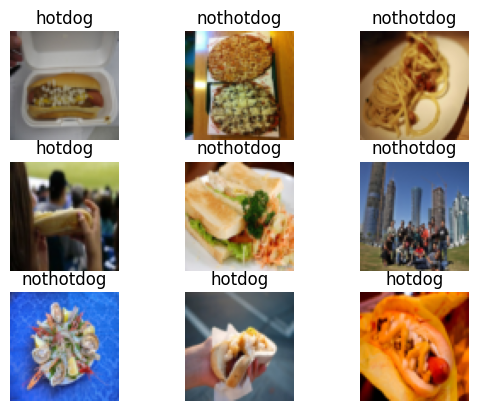

In [135]:
for i in range(9):
    plt.subplot(3,3,i+1)
    random_idx=torch.randint(0,len(train_data),size=[1]).item()
    img,lab=train_data[random_idx]
    print(lab)
    ImageShow(img,lab)

In [136]:
class HotDogDetector(nn.Module):
    def __init__(self,input_features,output_features,hidden_units):
        super().__init__()
        self.conv_1=nn.Sequential(
            nn.Conv2d(in_channels=input_features,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_2=nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            #nn.Linear(in_features=hidden_units*0,out_features=output_features)
            nn.Linear(in_features=hidden_units*16*16,out_features=output_features)
        )
    def forward(self,x):
        x=self.conv_1(x)
        #print(x.shape)
        x=self.conv_2(x)
        #print(x.shape)
        x=self.classifier(x)
        return x
        

In [137]:
model_0=HotDogDetector(input_features=3,output_features=len(class_name),hidden_units=10)

In [138]:
optimizer=torch.optim.SGD(lr=0.1,params=model_0.parameters())
loss_fn=nn.CrossEntropyLoss()

In [139]:
def trainig_step(model:nn.Module,
                dataloader:torch.utils.data.dataloader,
                optimizer:torch.optim,
                loss_fn:nn.Module,
                accuracy_fn,
                device
                ):
    model.train()
    train_acc,train_loss=0,0
    for batch,(X,y) in enumerate(dataloader):
        X,y=X.to(device),y.to(device)
        y_pred=model(X)
        loss=loss_fn(y_pred,y)
        train_loss+=loss

        acc=accuracy_fn(y,y_pred.argmax(dim=1))

        train_acc+=acc
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()

        if batch%10==0:
            print(f"{batch * len(X)}/{len(dataloader.dataset)} Accuracy:{acc}")
            
    train_acc/=len(dataloader)
    train_loss/=len(dataloader)
    print(f"Train_Acc={train_acc*100},Train_Loss={train_loss}")            
        
        
    

In [140]:
def testing_step(model:nn.Module,
                dataloader:torch.utils.data.dataloader,
                optimizer:torch.optim,
                loss_fn:nn.Module,
                accuracy_fn,
                device
                ):
    model.eval()
    test_loss,test_acc=0,0
    with torch.inference_mode():
        for X,y in dataloader:
            X,y=X.to(device),y.to(device)
            y_pred=model(X)

            loss=loss_fn(y_pred,y)
            test_loss+=loss

            acc=accuracy_fn(y,y_pred.argmax(dim=1))
            test_acc+=acc

        test_acc/=len(dataloader)
        test_loss/=len(dataloader)

        print(f"TestLoss{test_loss} TestAccuracy{test_acc*100}")

In [141]:
from sklearn.metrics import accuracy_score

In [142]:
from tqdm.auto import tqdm
from timeit import default_timer as timer
start=timer()
epochs=1

for epoch in tqdm(range(epochs)):
    print(f"Epochs{epoch}")
    trainig_step(model_0,train_dataloader,optimizer,loss_fn,accuracy_score,device)
    testing_step(model_0,test_dataloader,optimizer,loss_fn,accuracy_score,device)

end=timer()

print(f"Training time={end-start}")

  0%|          | 0/1 [00:00<?, ?it/s]

Epochs0
0/5140 Accuracy:0.53125
320/5140 Accuracy:0.5
640/5140 Accuracy:0.65625
960/5140 Accuracy:0.625
1280/5140 Accuracy:0.53125
1600/5140 Accuracy:0.65625
1920/5140 Accuracy:0.78125
2240/5140 Accuracy:0.5625
2560/5140 Accuracy:0.4375
2880/5140 Accuracy:0.59375
3200/5140 Accuracy:0.71875
3520/5140 Accuracy:0.59375
3840/5140 Accuracy:0.59375
4160/5140 Accuracy:0.6875
4480/5140 Accuracy:0.6875
4800/5140 Accuracy:0.5
3200/5140 Accuracy:0.6
Train_Acc=58.73835403726708,Train_Loss=0.6797872185707092
TestLoss0.6292808055877686 TestAccuracy74.625
Training time=48.29682299999695
